# Text Clustering

In [12]:
import json

dataset_filepath = "./medical_meadow_wikidoc_medical_flashcards.json"

with open(dataset_filepath, "r") as f:
    dataset = json.load(f)

In [13]:
print("Number of flashcards: ", len(dataset))

for key, value in dataset[33].items():
    print(key, ":", value)

Number of flashcards:  33955
instruction : Answer this question truthfully
input : What conditions present with high CK and bilateral proximal muscle weakness?
output : Myositis is a condition that presents with high CK and bilateral proximal muscle weakness.


In [14]:
documents = [f"{sample['input']}\n{sample['output']}" for sample in dataset]
print("Number of documents: ", len(documents))

Number of documents:  33955


## How does the vocabulary size change w.r.t. the minimum and maximum document frequency?
We'll use different voculabary size to analyze how the clustering algorithms perform

In [15]:
from typing import TypedDict
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from itertools import product


class Vectorizer(TypedDict):
    vectorizer: TfidfVectorizer
    min_df: int
    max_df: float


min_dfs = list(range(2, 15, 6))
max_dfs = [0.9, 0.5, 0.1]
print("min_dfs: ", min_dfs)
print("max_dfs: ", max_dfs)
vectorizers: list[Vectorizer] = []
combinations = list(product(min_dfs, max_dfs))
for min_df, max_df in combinations:
    vectorizer = TfidfVectorizer(stop_words="english", min_df=min_df, max_df=max_df)
    vectorizers.append({"vectorizer": vectorizer, "min_df": min_df, "max_df": max_df})

min_dfs:  [2, 8, 14]
max_dfs:  [0.9, 0.5, 0.1]


In [16]:
for vectorizer in vectorizers:
    vectorizer["vectorizer"].fit(documents)

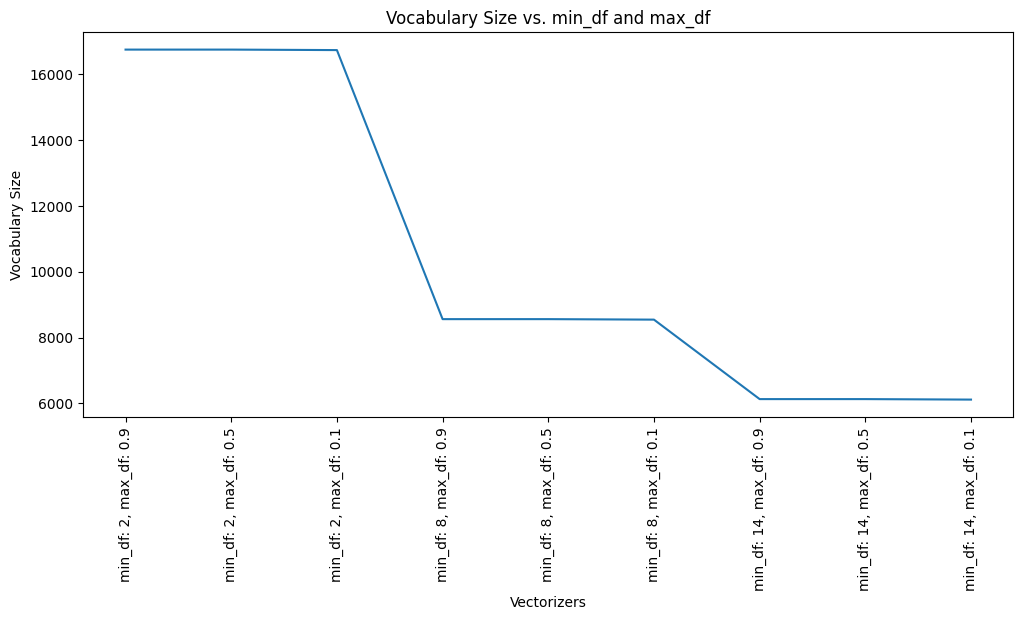

In [17]:
import matplotlib.pyplot as plt

sizes = []
for vectorizer in vectorizers:
    vocab_size = len(vectorizer["vectorizer"].get_feature_names_out())
    sizes.append(vocab_size)

plt.figure(figsize=(12, 5))  # Increase the width to 12
plt.plot(range(len(vectorizers)), sizes)
plt.xticks(
    range(len(vectorizers)),
    [
        f"min_df: {vectorizer['min_df']}, max_df: {vectorizer['max_df']}"
        for vectorizer in vectorizers
    ],
    rotation=90,
)
plt.xlabel("Vectorizers")
plt.ylabel("Vocabulary Size")
plt.title("Vocabulary Size vs. min_df and max_df")
plt.show()

In [18]:
from scipy.sparse import spmatrix


class VectorDocuments(TypedDict):
    vectorizer: Vectorizer
    vector_documents: spmatrix


vector_documents: list[VectorDocuments] = []

for vectorizer in vectorizers:
    vector_documents.append(
        {
            "vectorizer": vectorizer,
            "vector_documents": vectorizer["vectorizer"].transform(documents),
        }
    )

# Clustering with K-Means


In [19]:
from sklearn.cluster import KMeans, MiniBatchKMeans


class KMeansModel(TypedDict):
    kmeans: KMeans
    n_clusters: int
    vector_documents: VectorDocuments


kmeans_models: list[KMeansModel] = []
n_clusters = [10, 100, 500, 700]

for vector_document in vector_documents:
    min_df = vector_document["vectorizer"]["min_df"]
    max_df = vector_document["vectorizer"]["max_df"]
    for k in n_clusters:
        print(
            f"Training KMeans with {k} clusters, Vectorizer with min_df: {min_df}, max_df: {max_df}"
        )
        kmeans = KMeans(
            n_clusters=k,
            max_iter=100,
            n_init=1,
            verbose=False,
            random_state=2307,
        )
        # kmeans = MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=2307)
        kmeans.fit(vector_document["vector_documents"])
        kmeans_models.append(
            {
                "kmeans": kmeans,
                "n_clusters": k,
                "vector_documents": vector_document,
            }
        )

Training KMeans with 10 clusters, Vectorizer with min_df: 2, max_df: 0.9
Training KMeans with 100 clusters, Vectorizer with min_df: 2, max_df: 0.9
Training KMeans with 500 clusters, Vectorizer with min_df: 2, max_df: 0.9
Training KMeans with 700 clusters, Vectorizer with min_df: 2, max_df: 0.9
Training KMeans with 10 clusters, Vectorizer with min_df: 2, max_df: 0.5
Training KMeans with 100 clusters, Vectorizer with min_df: 2, max_df: 0.5
Training KMeans with 500 clusters, Vectorizer with min_df: 2, max_df: 0.5
Training KMeans with 700 clusters, Vectorizer with min_df: 2, max_df: 0.5
Training KMeans with 10 clusters, Vectorizer with min_df: 2, max_df: 0.1
Training KMeans with 100 clusters, Vectorizer with min_df: 2, max_df: 0.1
Training KMeans with 500 clusters, Vectorizer with min_df: 2, max_df: 0.1
Training KMeans with 700 clusters, Vectorizer with min_df: 2, max_df: 0.1
Training KMeans with 10 clusters, Vectorizer with min_df: 8, max_df: 0.9
Training KMeans with 100 clusters, Vectori

# Intrinsic evalutation of K-Means clusters

## K-Means Within-cluster sum-of-squares (Inertia)

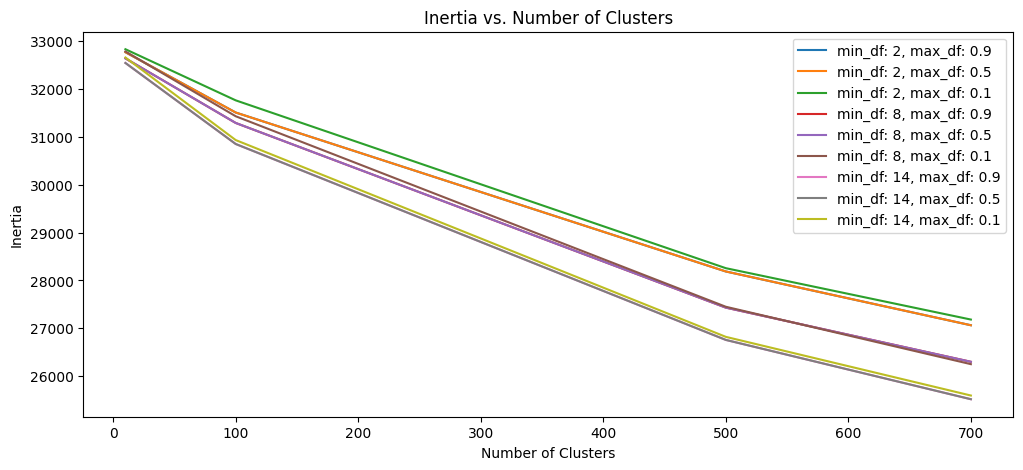

In [23]:
plt.figure(figsize=(12, 5))
for vectorizer in vectorizers:
    inertias = []
    for kmeans_model in kmeans_models:
        if kmeans_model["vector_documents"]["vectorizer"] == vectorizer:
            inertias.append(kmeans_model["kmeans"].inertia_)
    plt.plot(
        n_clusters,
        inertias,
        label=f"min_df: {vectorizer['min_df']}, max_df: {vectorizer['max_df']}",
    )
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Inertia vs. Number of Clusters")
plt.legend()
plt.show()

## K-Means Silhouette

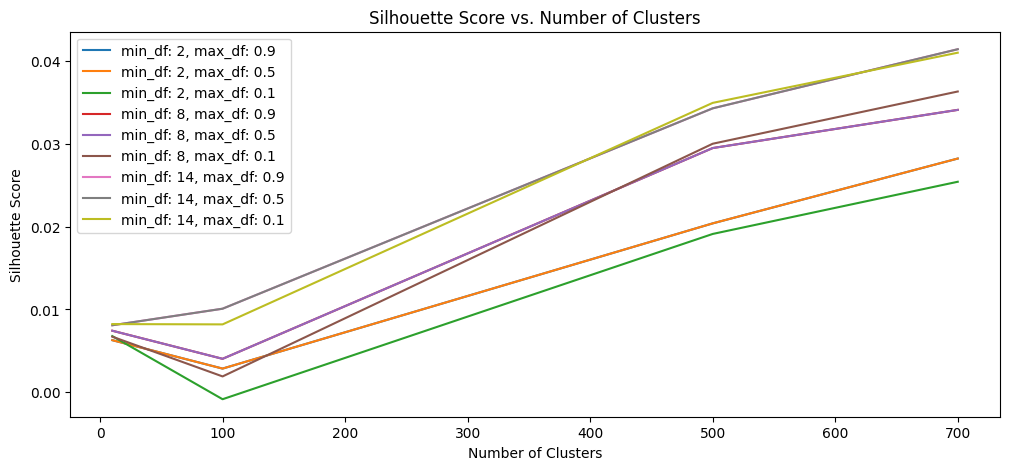

In [24]:
from sklearn import metrics

plt.figure(figsize=(12, 5))
for vectorizer in vectorizers:
    silhouette_scores = []
    for kmeans_model in kmeans_models:
        if kmeans_model["vector_documents"]["vectorizer"] == vectorizer:
            silhouette_score = metrics.silhouette_score(
                kmeans_model["vector_documents"]["vector_documents"],
                kmeans_model["kmeans"].labels_,
            )
            silhouette_scores.append(silhouette_score)
    plt.plot(
        n_clusters,
        silhouette_scores,
        label=f"min_df: {vectorizer['min_df']}, max_df: {vectorizer['max_df']}",
    )
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend()
plt.show()

Using the elbow "method" we can set as number of clusters 500. \\
For the `TfidfVectorizer` we can pick the one with `min_df=8` and `max_df=0.5`

## Look at the clusters of this model


In [25]:
print("Top terms per cluster:")
best_n_clusters = 500
best_min_df = 8
best_max_df = 0.5
best_kmeans_model = None
for kmeans_model in kmeans_models:
    if (
        kmeans_model["n_clusters"] == best_n_clusters
        and kmeans_model["vector_documents"]["vectorizer"]["min_df"] == best_min_df
        and kmeans_model["vector_documents"]["vectorizer"]["max_df"] == best_max_df
    ):
        best_kmeans_model = kmeans_model
        break

vocab = best_kmeans_model["vector_documents"]["vectorizer"][
    "vectorizer"
].get_feature_names_out()
# Get the first 20 clusters of the best kmeans model
for i in range(best_n_clusters):
    centroid = best_kmeans_model["kmeans"].cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['unit', 'functional', 'ovaries', 'consist', 'surrounded', 'follicle', 'endocrine', 'germ', 'single', 'ovarian']
Cluster 1:	['eosinophilia', 'infection', 'hematologic', 'parasitic', 'eosinophils', 'worm', 'complication', 'parasite', 'including', 'finding']
Cluster 2:	['heart', 'blood', 'pressure', 'failure', 'flow', 'hypertension', 'vessels', 'left', 'right', 'increase']
Cluster 3:	['acidosis', 'tubular', 'renal', 'rta', 'type', 'metabolic', 'anion', 'gap', 'caused', 'hyperkalemic']
Cluster 4:	['gene', 'suppressor', 'tumor', 'mutations', 'mutation', 'protein', 'development', 'genes', 'encodes', 'associated']
Cluster 5:	['lymphocytic', 'leukemia', 'cll', 'chronic', 'cells', 'blood', 'lymphadenopathy', 'rituximab', 'cd20', 'lymphocytes']
Cluster 6:	['used', 'patients', 'treatment', 'associated', 'cause', 'condition', 'disease', 'patient', 'symptoms', 'type']
Cluster 7:	['leishmaniasis', 'leishmania', 'visceral', 'form', 'spp', 'protozoa', 'macrophages', 

## Let's see how the documents are distributed among the clusters

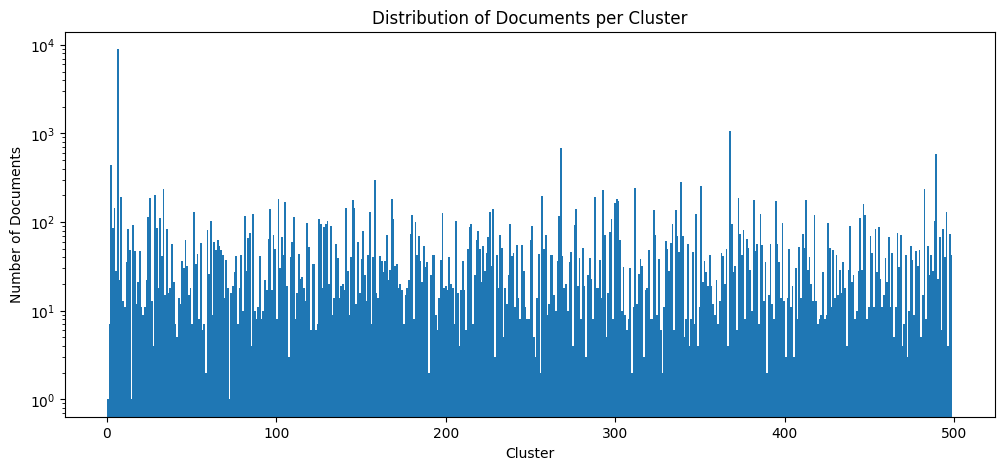

In [26]:
# plot the distribution of docs per cluster for the best model
plt.figure(figsize=(12, 5))
plt.hist(best_kmeans_model["kmeans"].labels_, bins=best_n_clusters)
plt.xlabel("Cluster")
plt.ylabel("Number of Documents")
plt.yscale("log")
plt.title("Distribution of Documents per Cluster")
plt.show()

# Clustering with LDA


In [27]:
from sklearn.model_selection import train_test_split

documents_train, documents_test = train_test_split(
    documents, test_size=0.2, random_state=2307
)
print("No. training docs:", len(documents_train))
print("No. testing docs:", len(documents_test))

No. training docs: 27164
No. testing docs: 6791


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

min_dfs = list(range(2, 15, 6))
max_dfs = [0.9, 0.5, 0.1]
combinations = list(product(min_dfs, max_dfs))

count_vectorizers = []
for min_df, max_df in combinations:
    vectorizer = CountVectorizer(stop_words="english", min_df=min_df, max_df=max_df)
    vector_documents_train = vectorizer.fit_transform(documents_train)
    count_vectorizers.append(
        {
            "vectorizer": vectorizer,
            "min_df": min_df,
            "max_df": max_df,
            "vector_documents": vector_documents_train,
        }
    )

In [29]:
from sklearn.decomposition import LatentDirichletAllocation


class LDAModel(TypedDict):
    lda: LatentDirichletAllocation
    n_components: int
    min_df: int
    max_df: float


lda_models = []
n_components = [50, 100, 300]

for n_component in n_components:
    for count_vectorizer in count_vectorizers:
        min_df = count_vectorizer["min_df"]
        max_df = count_vectorizer["max_df"]
        print(
            f"Training LDA with {n_component} components, CountVectorizer with min_df: {min_df}, max_df: {max_df}"
        )
        lda = LatentDirichletAllocation(
            n_components=n_component,
            max_iter=30,
            random_state=2307,
        )
        lda.fit(count_vectorizer["vector_documents"])
        lda_models.append(
            {
                "lda": lda,
                "n_components": n_component,
                "min_df": min_df,
                "max_df": max_df,
            }
        )

Training LDA with 50 components, CountVectorizer with min_df: 2, max_df: 0.9
Training LDA with 50 components, CountVectorizer with min_df: 2, max_df: 0.5
Training LDA with 50 components, CountVectorizer with min_df: 2, max_df: 0.1
Training LDA with 50 components, CountVectorizer with min_df: 8, max_df: 0.9
Training LDA with 50 components, CountVectorizer with min_df: 8, max_df: 0.5
Training LDA with 50 components, CountVectorizer with min_df: 8, max_df: 0.1
Training LDA with 50 components, CountVectorizer with min_df: 14, max_df: 0.9
Training LDA with 50 components, CountVectorizer with min_df: 14, max_df: 0.5
Training LDA with 50 components, CountVectorizer with min_df: 14, max_df: 0.1
Training LDA with 100 components, CountVectorizer with min_df: 2, max_df: 0.9
Training LDA with 100 components, CountVectorizer with min_df: 2, max_df: 0.5
Training LDA with 100 components, CountVectorizer with min_df: 2, max_df: 0.1
Training LDA with 100 components, CountVectorizer with min_df: 8, max_

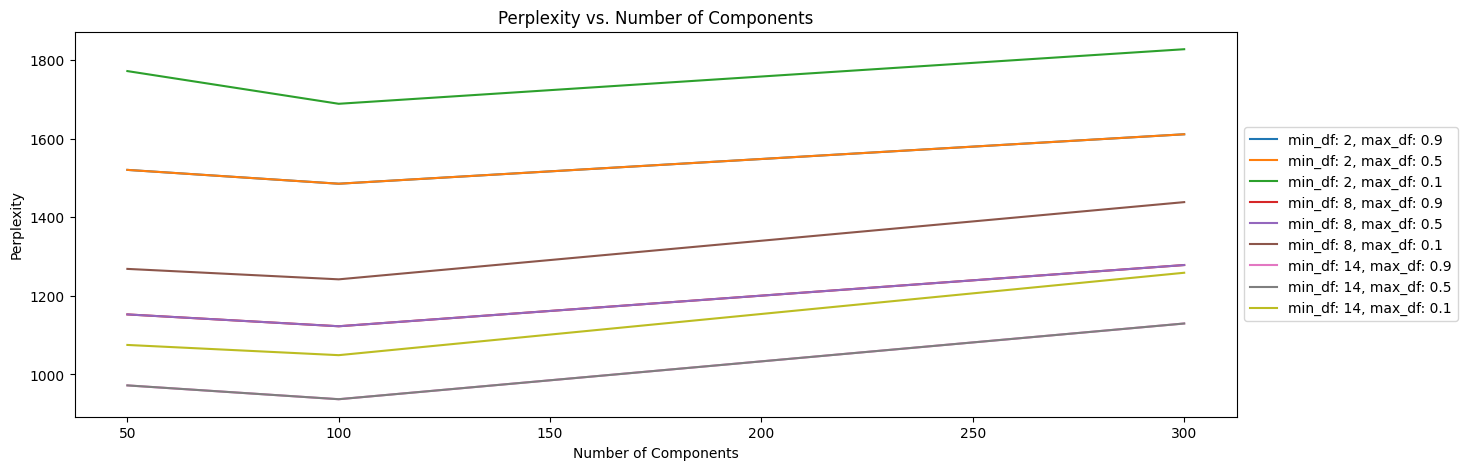

In [30]:
plt.figure(figsize=(15, 5))
for count_vectorizer in count_vectorizers:
    perplexities = []
    for lda_model in lda_models:
        if (
            lda_model["min_df"] == count_vectorizer["min_df"]
            and lda_model["max_df"] == count_vectorizer["max_df"]
        ):
            perplexities.append(
                lda_model["lda"].perplexity(count_vectorizer["vector_documents"])
            )
    plt.plot(
        n_components,
        perplexities,
        label=f"min_df: {count_vectorizer['min_df']}, max_df: {count_vectorizer['max_df']}",
    )
plt.xlabel("Number of Components")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Number of Components")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Using the elbow "method" we can set as number of clusters 100. \\
For the `CountVectorizer` we can pick the one with `min_df=14` and `max_df=0.5`

In [31]:
best_n_components = 100
best_min_df = 14
best_max_df = 0.5
best_lda_model = None
for lda_model in lda_models:
    if (
        lda_model["n_components"] == best_n_components
        and lda_model["min_df"] == best_min_df
        and lda_model["max_df"] == best_max_df
    ):
        best_lda_model = lda_model
        break

best_count_vectorizer = None
for count_vectorizer in count_vectorizers:
    if (
        count_vectorizer["min_df"] == best_min_df
        and count_vectorizer["max_df"] == best_max_df
    ):
        best_count_vectorizer = count_vectorizer
        break

# get the top 10 words for each topic
vocab = best_count_vectorizer["vectorizer"].get_feature_names_out()
for i, topic in enumerate(best_lda_model["lda"].components_):
    print(f"Topic {i}:\t{[vocab[j] for j in topic.argsort()[:-11:-1]]}")

Topic 0:	['glucose', 'insulin', 'diabetes', 'blood', 'levels', 'diabetic', 'sugar', 'warfarin', 'glycogen', 'hypoglycemia']
Topic 1:	['life', 'threatening', 'cause', 'potentially', 'death', 'lead', 'endocarditis', 'untreated', 'blood', 'emergency']
Topic 2:	['peripheral', 'dysfunction', 'symptoms', 'lower', 'adenocarcinoma', 'upper', 'weakness', 'foot', 'numbness', 'neurological']
Topic 3:	['healthcare', 'provider', 'important', 'recommended', 'individual', 'appropriate', 'treatment', 'history', 'determine', 'patient']
Topic 4:	['serotonin', 'receptor', 'receptors', 'nsaids', 'adrenergic', 'opioid', 'agonists', 'dopamine', 'primarily', 'antagonists']
Topic 5:	['age', 'time', 'child', 'typically', 'period', 'months', 'years', 'old', 'develop', 'children']
Topic 6:	['line', 'considered', 'aortic', 'aorta', 'size', 'treatment', 'dissection', 'aneurysm', 'giant', 'anal']
Topic 7:	['fever', 'post', 'infection', 'discharge', 'streptococcus', 'cause', 'glomerulonephritis', 'chlamydia', 'hemat

## Let's see how the documents are distributed among the clusters

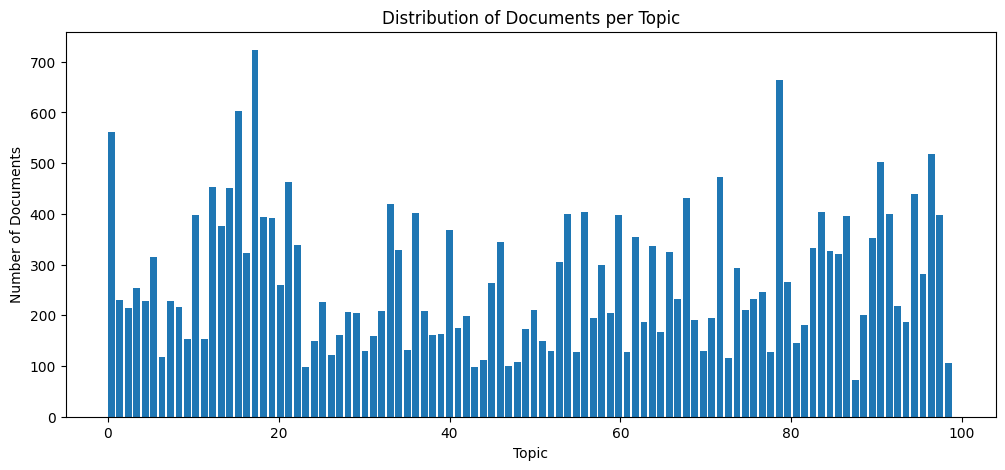

In [37]:
# plot the distribution of docs per topic for the best lda model
doc_topic_dist = best_lda_model["lda"].transform(best_count_vectorizer["vector_documents"])
dominant_topics = doc_topic_dist.argmax(axis=1)

plt.figure(figsize=(12, 5))
plt.hist(dominant_topics, bins=best_n_components, width=0.8)
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Distribution of Documents per Topic")
plt.show()